In [1]:
import sys

sys.path.append("..")

### Test

In [2]:
from typing import List, Dict
from pathlib import Path
from PIL import Image
from segment.utils import resize_image_pil
from segment.dino_script import get_dino_results
from segment.sam_script import get_sam_results
from segment.utils import get_device
from segment.sam_results import SAMResults
from diffusers.utils import load_image
from segment.sam_script import get_sam_results

DEVICE = get_device()


def load_resize_image(image_path):
    image_pil = load_image(image_path).convert("RGB")
    image_pil = resize_image_pil(image_pil, 1024)
    return image_pil


def get_masks(
    text_prompt, image_paths: List[str], labels_dict: Dict[str, int]
) -> SAMResults:
    device = get_device()

    images = [load_resize_image(url) for url in image_paths]

    # Get the boxes from the prompts using DINO
    dino_results = get_dino_results(images, text_prompt, device)

    # Get the masks from the images and boxes using SAM
    unformatted_results = get_sam_results(images, dino_results, text_prompt, device)

    sam_results = SAMResults(
        images[0], labels_dict, **unformatted_results[0], person_masks_only=False
    )
    return sam_results

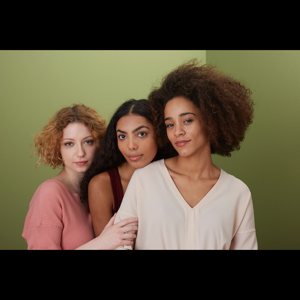

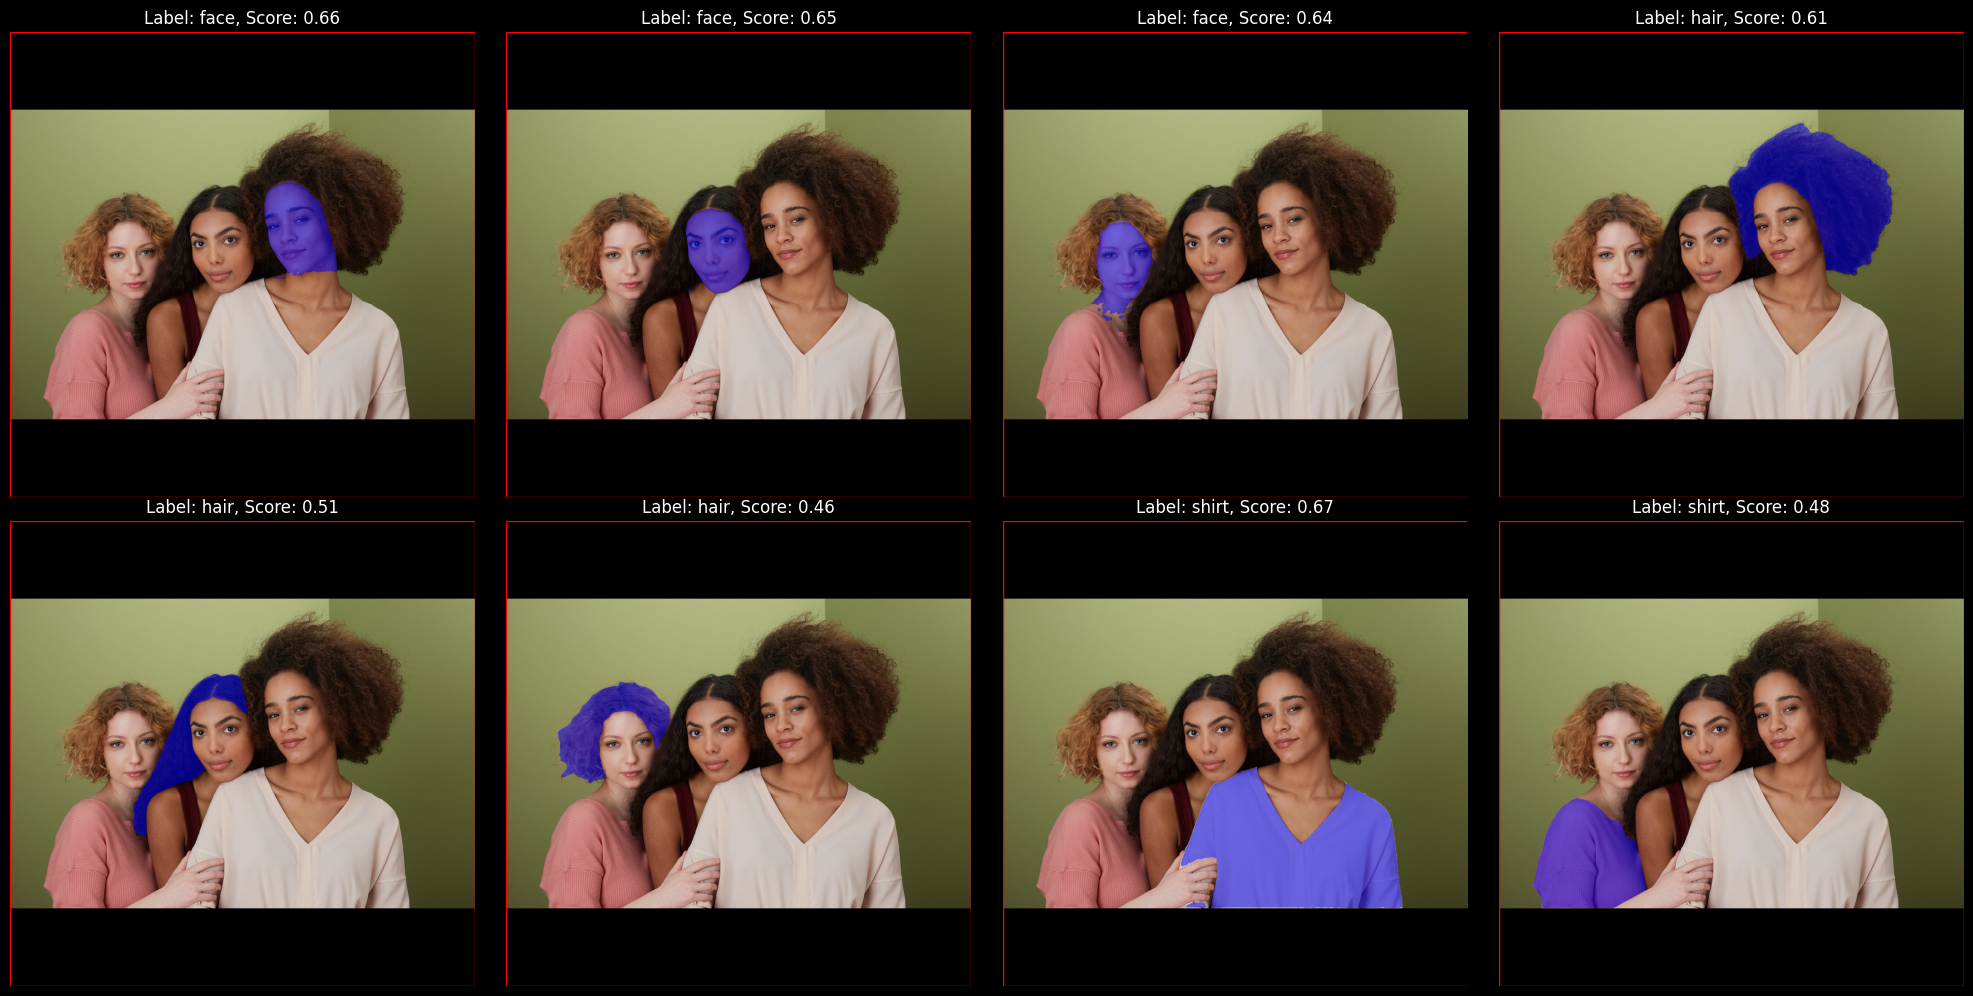

In [7]:
text_prompt = ["hair", "shirt", "face"]

text_prompt = ".".join(text_prompt)

labels_dict = {prompt.strip(): idx for idx, prompt in enumerate(text_prompt.split("."))}

url = "https://media.glamour.com/photos/5bb373f13f965a344b7bcd15/master/w_2560%2Cc_limit/Support-women-lede.jpg"

sam_results = get_masks(text_prompt, [url], labels_dict)

display(load_resize_image(url).resize((300,300)))
sam_results.display_results()